In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

### Reading and exploring the data

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
layer_height,50.0,0.106,0.064397,0.02,0.06,0.10,0.150,0.2
wall_thickness,50.0,5.220,2.922747,1.00,3.00,5.00,7.000,10.0
infill_density,50.0,53.400,25.363480,10.00,40.00,50.00,80.000,90.0
nozzle_temperature,50.0,221.500,14.820353,200.00,210.00,220.00,230.000,250.0
bed_temperature,50.0,70.000,7.142857,60.00,65.00,70.00,75.000,80.0
print_speed,50.0,64.000,29.692300,40.00,40.00,60.00,60.000,120.0
fan_speed,50.0,50.000,35.714286,0.00,25.00,50.00,75.000,100.0
roughness,50.0,170.580,99.034129,21.00,92.00,165.50,239.250,368.0
tension_strenght,50.0,20.080,8.925634,4.00,12.00,19.00,27.000,37.0
elongation,50.0,1.672,0.788188,0.40,1.10,1.55,2.175,3.3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        50 non-null     float64
 1   wall_thickness      50 non-null     int64  
 2   infill_density      50 non-null     int64  
 3   infill_pattern      50 non-null     object 
 4   nozzle_temperature  50 non-null     int64  
 5   bed_temperature     50 non-null     int64  
 6   print_speed         50 non-null     int64  
 7   material            50 non-null     object 
 8   fan_speed           50 non-null     int64  
 9   roughness           50 non-null     int64  
 10  tension_strenght    50 non-null     int64  
 11  elongation          50 non-null     float64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.8+ KB


In [6]:
df.isnull().sum()

layer_height          0
wall_thickness        0
infill_density        0
infill_pattern        0
nozzle_temperature    0
bed_temperature       0
print_speed           0
material              0
fan_speed             0
roughness             0
tension_strenght      0
elongation            0
dtype: int64

* Separating the numerical and categorical features

In [7]:
df_numeric = df.select_dtypes(['float64','int64'])
df_cat = df.select_dtypes('object')

In [8]:
df_numeric.head()

,layer_height,wall_thickness,infill_density,nozzle_temperature,bed_temperature,print_speed,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,220,60,40,0,25,18,1.2
1,0.02,7,90,225,65,40,25,32,16,1.4
2,0.02,1,80,230,70,40,50,40,8,0.8
3,0.02,4,70,240,75,40,75,68,10,0.5
4,0.02,6,90,250,80,40,100,92,5,0.7


### Visualizing distribution of numeric features

In [9]:
def plot_histogram(df):
    fig,axes = plt.subplots(5,2,figsize=(12,20),dpi=200)
    for ax, col in zip(axes.flatten(), df.columns):
        sns.histplot(df[col],kde=True,element='step',ax=ax)

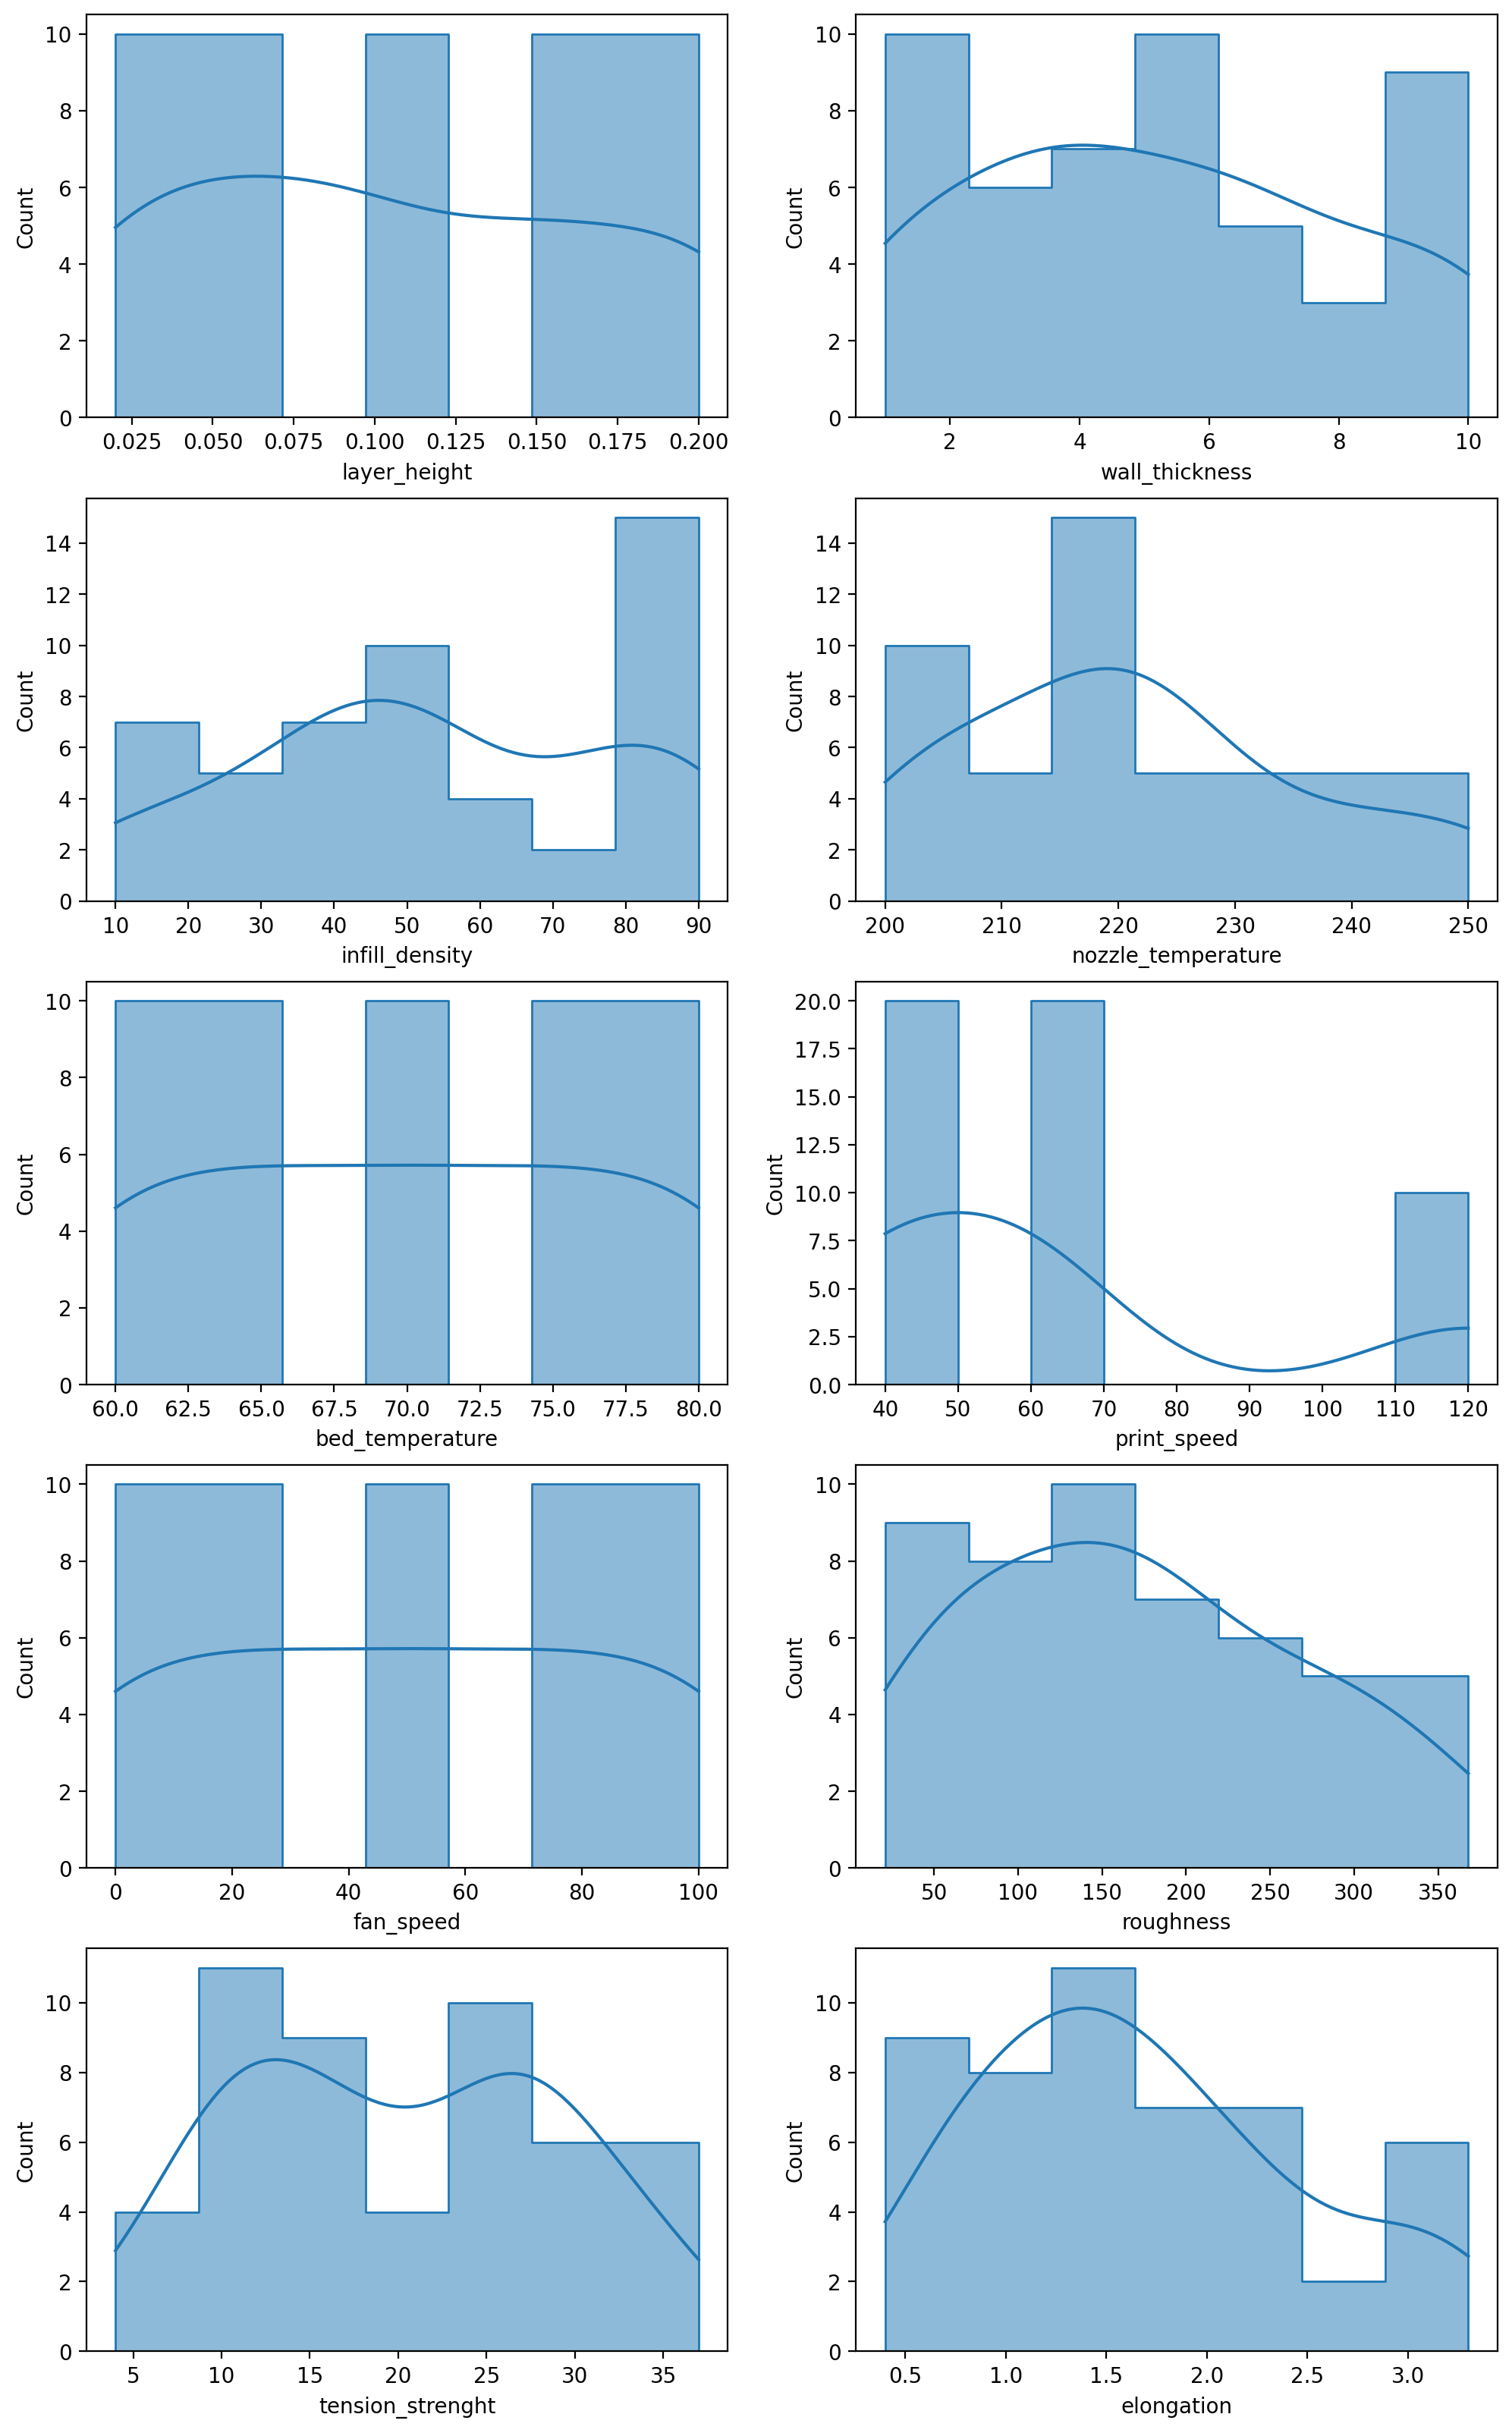

In [10]:
plot_histogram(df_numeric)

### Relationship between features

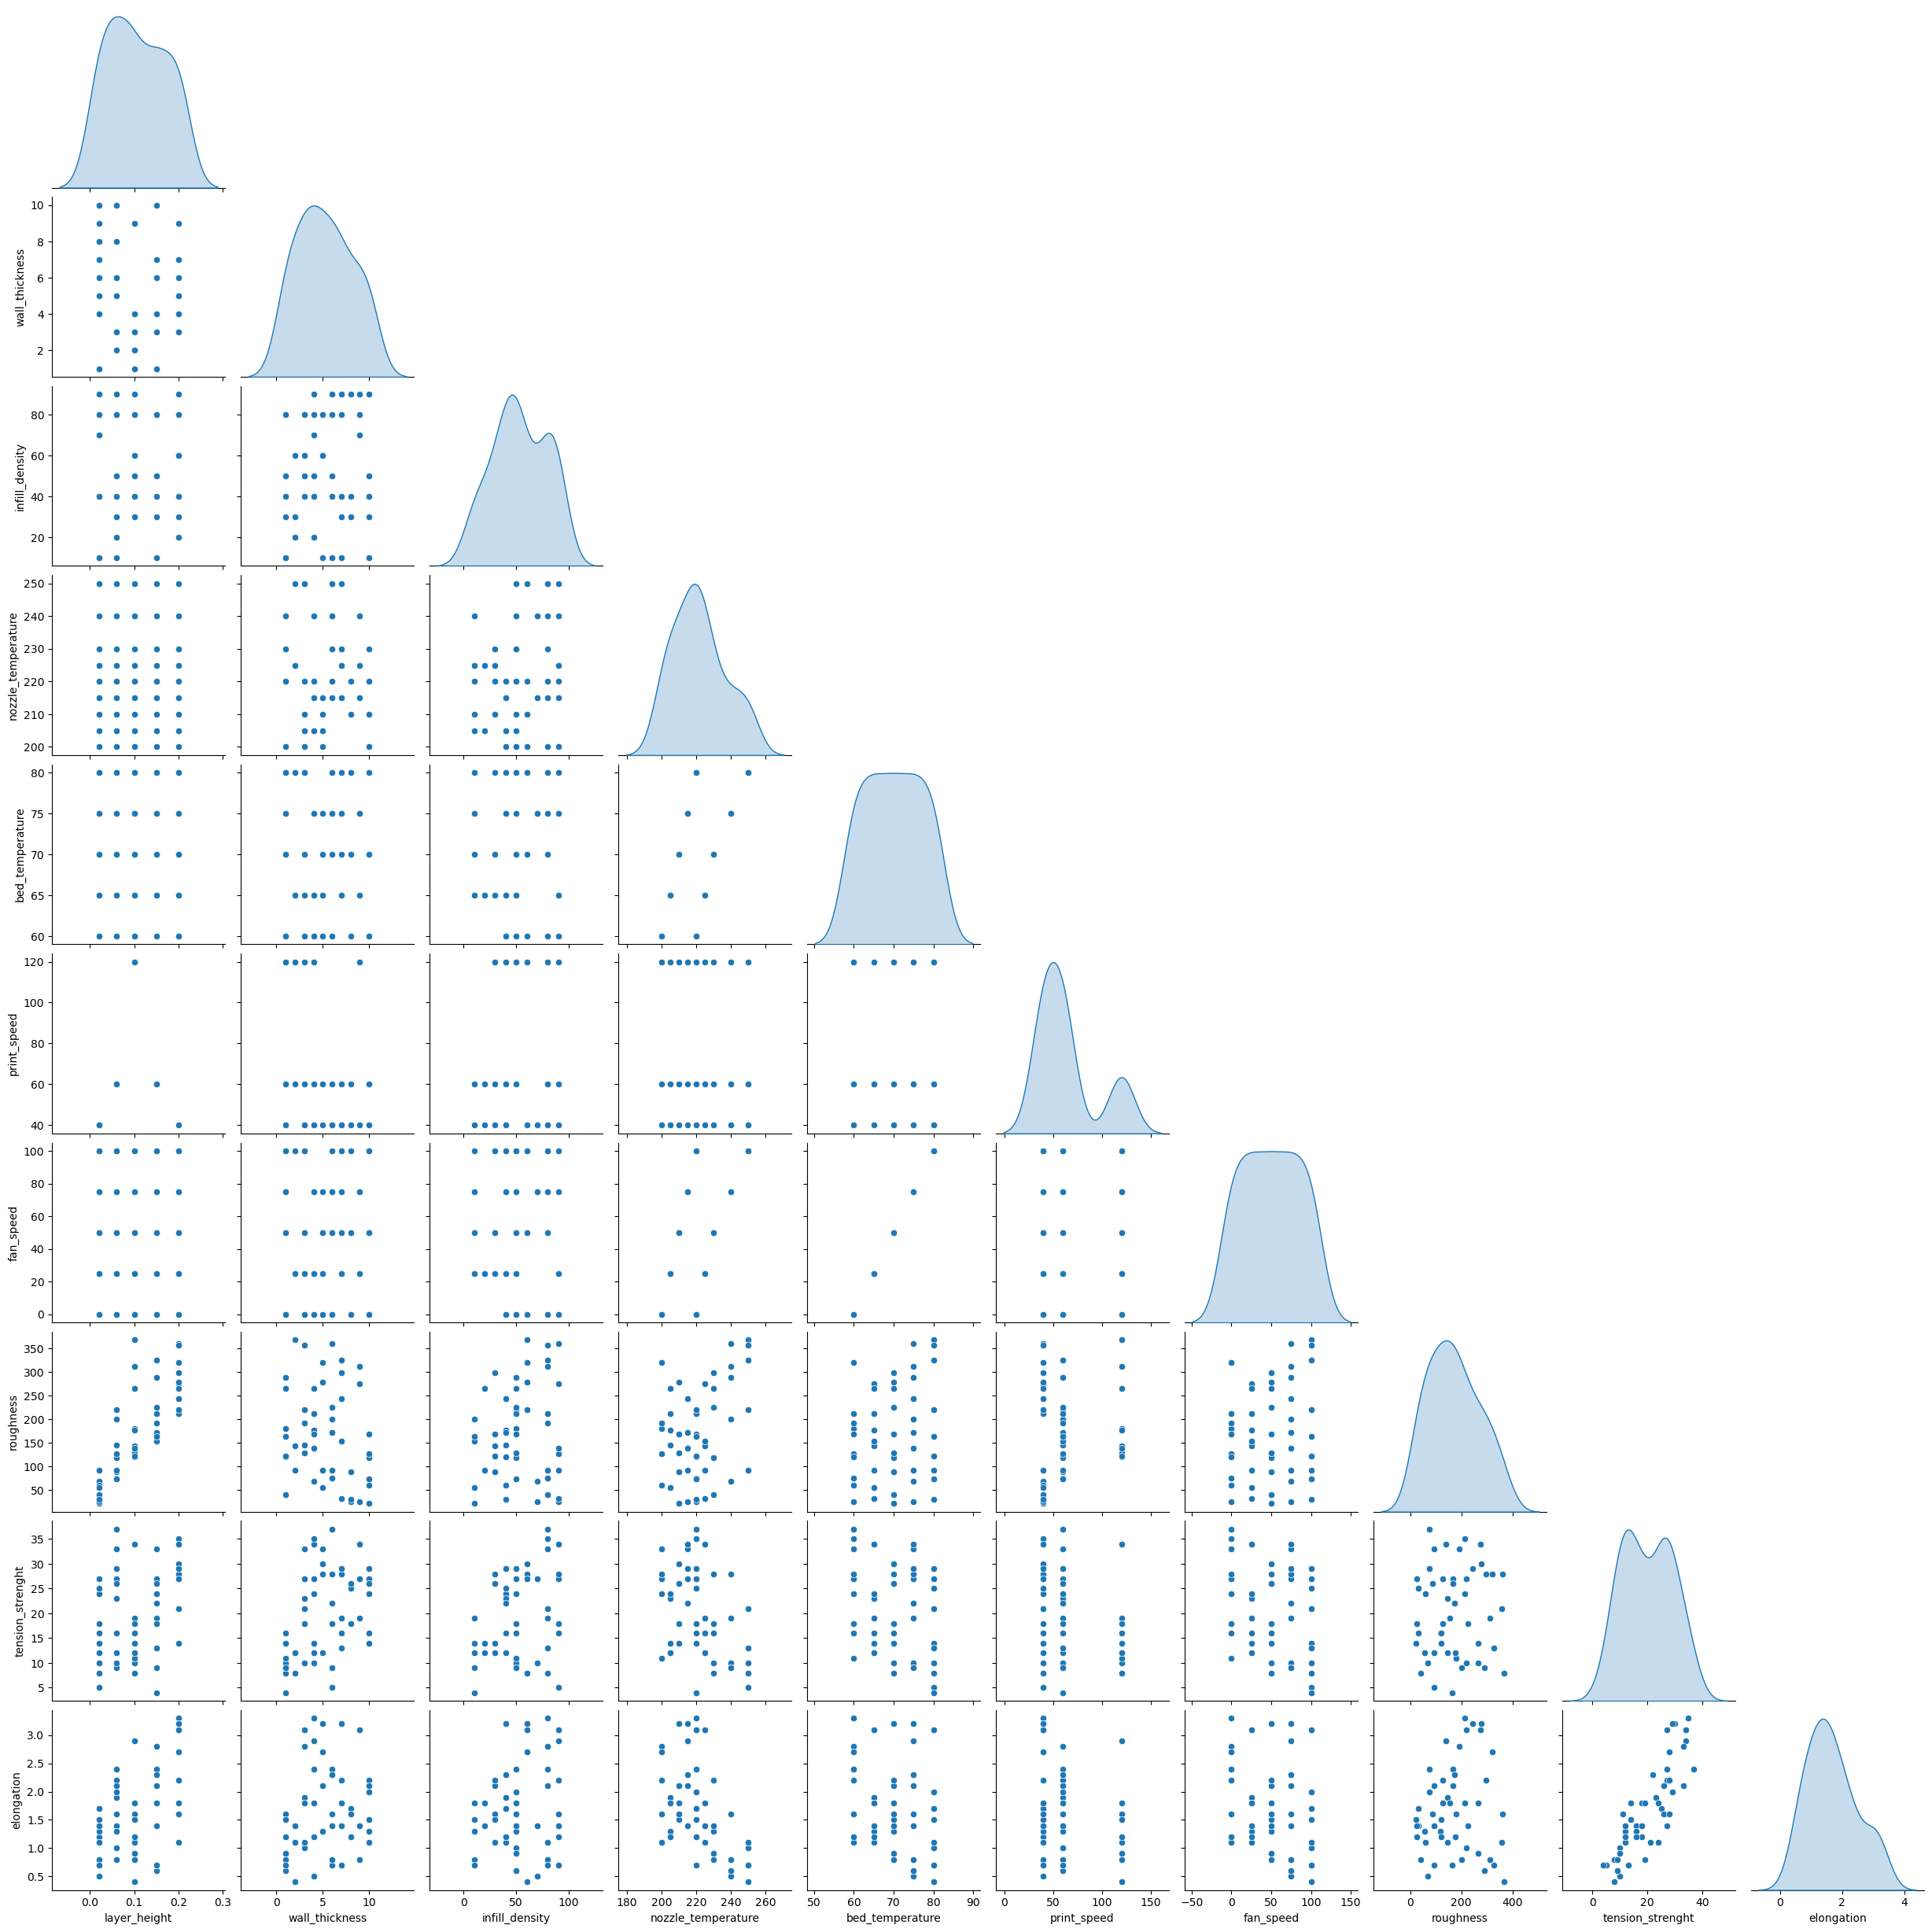

In [11]:
sns.pairplot(df,diag_kind='kde',corner=True)

* It is evident that some features are linearly correlated. So, there is some multicollinearity issue in the data. Also, the available data is limited. The expectation of normally distributed features is not viable in this case.

### Prediction of Tension Strength

In [12]:
Xt = df.drop('tension_strenght',axis=1)
yt = df['tension_strenght']

<AxesSubplot:>

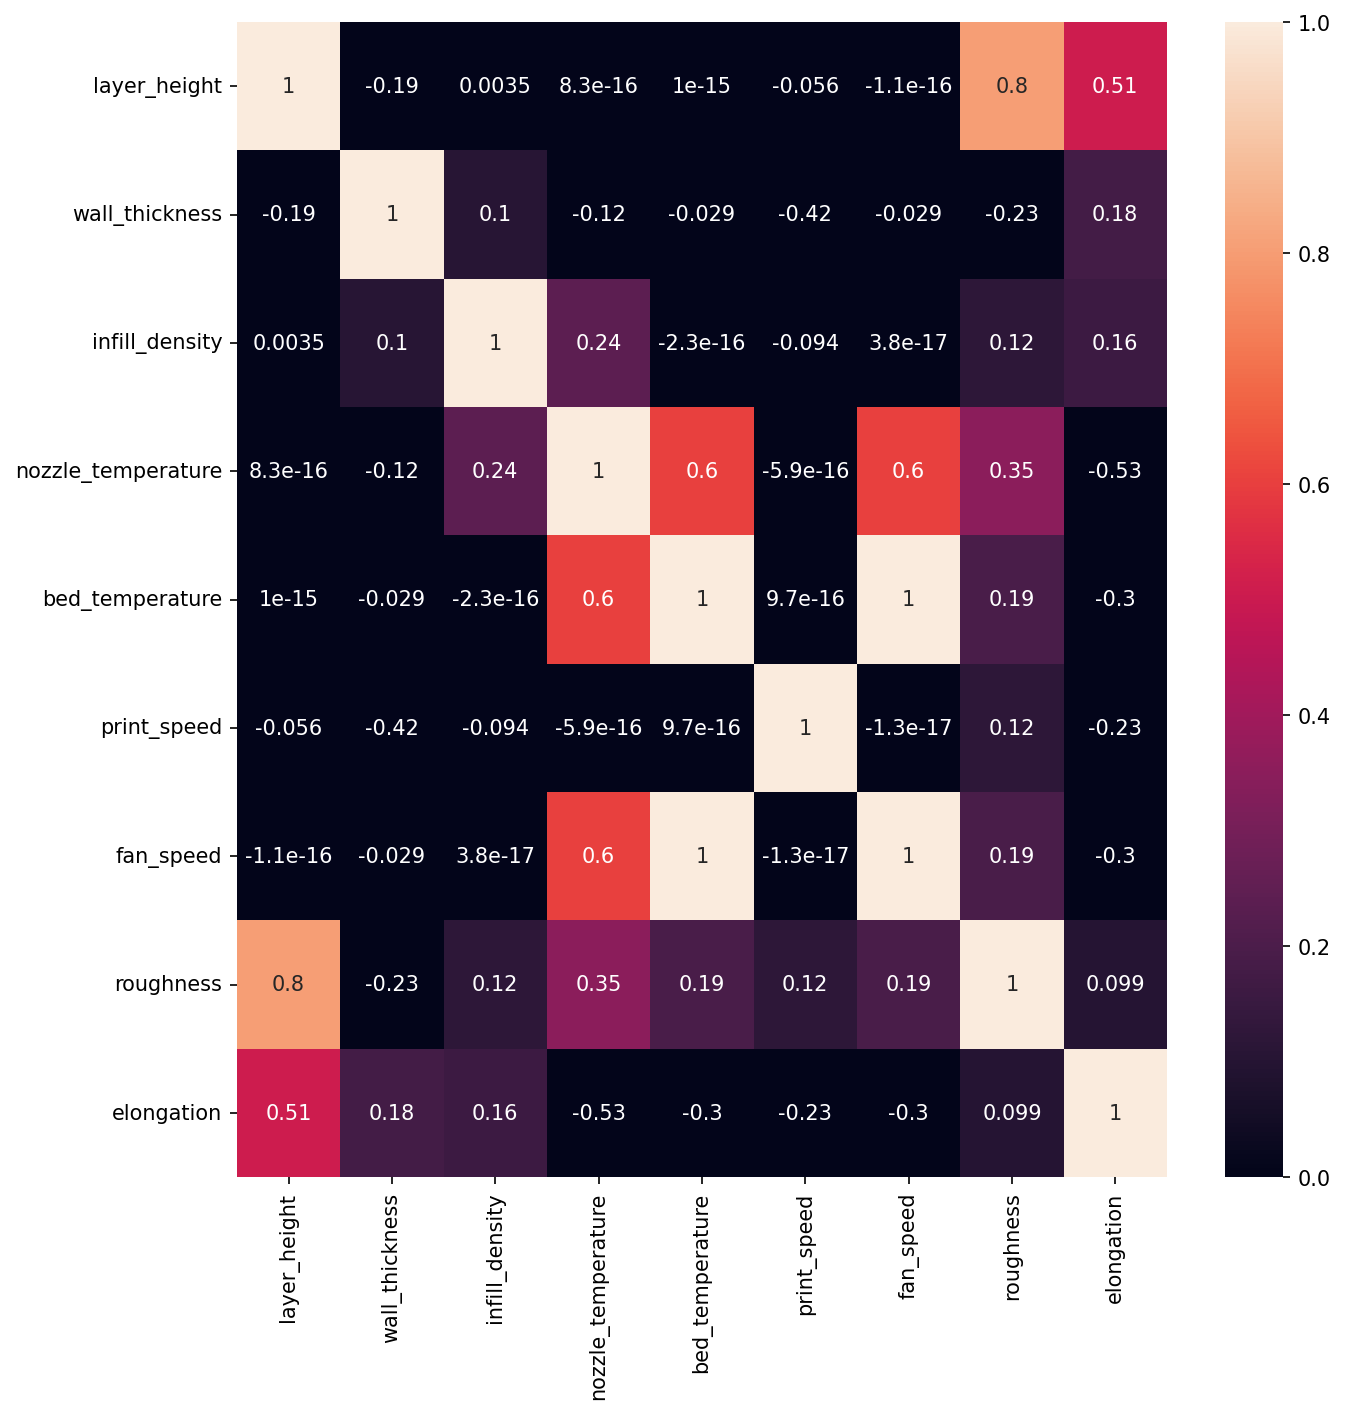

In [14]:
plt.figure(figsize=(10,10),dpi=150)
sns.heatmap(Xt.corr(),vmin=0,vmax=1,annot=True)

There are features which are highly correlated with each other. It helps if highly correlated features are removed.

In [15]:
def remove_corr(df, threshold):

    corr = pd.DataFrame(abs(df.corr()))

    Featurei = []
    Featurej = []
    Corr = []

    for i in corr.index:
        for j in corr.columns:
            if (corr.loc[i, j] > threshold and i != j):
                if(i not in Featurei and i not in Featurej):
                    Featurei.append(i)
                if(j not in Featurej and j not in Featurei):
                    Featurej.append(j)
                    Corr.append(corr.loc[i, j])
    
    d = pd.DataFrame([Featurei, Featurej, Corr]).transpose()
    display(d)
    
    to_drop = set(d[0])
    
    print('Number of features removed = ', len(to_drop))
    
    return (df.drop(to_drop, axis=1))

In [16]:
X1 = remove_corr(Xt,0.80)

,0,1,2
0,layer_height,roughness,0.801341
1,bed_temperature,fan_speed,1.0


Number of features removed =  2


In [17]:
# Encoding categorical features

X1['infill_pattern'] = np.where(X1['infill_pattern']=='grid',0,1)
X1['material'] = np.where(X1['material']=='pla',0,1)

In [18]:
X1_cat = X1[['material','infill_pattern']]

In [19]:
X1_num = X1.drop(['material','infill_pattern'],axis=1)

In [20]:
# Scaling numerical features

sc = StandardScaler()
X1_sc = pd.DataFrame(sc.fit_transform(X1_num), columns=X1_num.columns)

In [21]:
X_final = pd.concat([X1_cat,X1_sc],axis=1,join='inner')

In [22]:
X_final = X_final.sample(frac=1)

In [23]:
X_final

,material,infill_pattern,wall_thickness,infill_density,nozzle_temperature,print_speed,fan_speed,roughness,elongation
29,0,1,-1.458506,-0.931953,-0.102240,1.905159,1.414214,-0.505718,-0.220437
4,1,0,0.269582,1.457670,1.942555,-0.816497,1.414214,-0.801520,-1.245728
32,1,0,0.269582,-0.135412,0.579358,-0.136083,0.000000,0.555086,-0.348599
38,0,0,0.269582,-0.533682,-0.443039,-0.136083,0.707107,0.014484,0.804853
49,0,1,-0.767271,0.262859,-0.102240,-0.816497,1.414214,0.504086,1.830144
33,1,1,-1.458506,-0.135412,1.260957,-0.136083,0.707107,1.207889,-1.373889
25,0,1,-1.458506,-0.135412,-1.465436,1.905159,-1.414214,0.096084,-0.092276
13,1,1,0.269582,-1.728494,1.260957,-0.136083,0.707107,0.300085,-1.117567
30,1,0,-0.421653,-0.135412,-0.102240,-0.136083,-1.414214,-0.026316,0.933014
39,0,1,-1.458506,-1.728494,-0.102240,-0.136083,1.414214,-0.077316,-1.245728


In [25]:
mod1 = RandomForestRegressor()
mod2 = LinearRegression()
mod1_cv = cross_validate(mod1,X_final,yt,scoring='neg_root_mean_squared_error',cv=10)
mod2_cv = cross_validate(mod2,X_final,yt,scoring='neg_root_mean_squared_error',cv=10)
print('RMSE = ', mod1_cv['test_score'].mean(),
      'with std. deviation: %.2f'%mod1_cv['test_score'].std())
print('RMSE = ', mod2_cv['test_score'].mean(),
     'with std. deviation: %.2f'%mod2_cv['test_score'].std())

RMSE =  -10.433308660923363 with std. deviation: 1.68
RMSE =  -10.853228032530572 with std. deviation: 2.42


**Random Forest model is the better model since it has comparatively low RMSE and better standard deviation.**

In [27]:
mod1.fit(X_final, yt)
y_pred = mod1.predict(X_final)
print('RMSE value: %.3f'%mean_squared_error(yt,y_pred,squared=False))
print('R2 score  : %.3f'%r2_score(yt,y_pred))

RMSE value: 3.752
R2 score  : 0.820


## Predicting the output parameters
**Features are not removed**

In [28]:
target = ['tension_strenght','roughness','print_speed']

for t in target:
    
    X = df.drop(t,axis=1)
    y = df[t]
    
    print('**************************************************')
    print('RMSE and r2 value for ',t)
    print('**************************************************')
    
    ohe = ColumnTransformer([('ohe',OneHotEncoder(),X.select_dtypes('object').columns)],remainder=StandardScaler())
    
    for m in [LinearRegression(),LogisticRegression(), SVR(), RandomForestRegressor()]:
        
        print('______________________________________________')
        print('Algorithm',m)
        
        lr = m
        model = Pipeline(steps=[('ohe',ohe),('lr',lr)])
        model.fit(X,y)
        y_pred = model.predict(X)
        
        print()
        print('The RMSE value: %.2f'%mean_squared_error(y,y_pred,squared=False))
        print('The r2 value: %.2f'%r2_score(y,y_pred))
        print()

**************************************************
RMSE and r2 value for  tension_strenght
**************************************************
______________________________________________
Algorithm LinearRegression()

The RMSE value: 3.77
The r2 value: 0.82

______________________________________________
Algorithm LogisticRegression()

The RMSE value: 4.25
The r2 value: 0.77

______________________________________________
Algorithm SVR()

The RMSE value: 6.66
The r2 value: 0.43

______________________________________________
Algorithm RandomForestRegressor()

The RMSE value: 1.73
The r2 value: 0.96

**************************************************
RMSE and r2 value for  roughness
**************************************************
______________________________________________
Algorithm LinearRegression()

The RMSE value: 33.39
The r2 value: 0.88

______________________________________________
Algorithm LogisticRegression()

The RMSE value: 6.22
The r2 value: 1.00

__________________

**Random Forest Regressor is the best model**